<a href="https://colab.research.google.com/github/hunnx27/Human-Falling-Detect-Tracks/blob/master/yolov8_sample_%EC%88%98%EC%97%85%EC%9E%90%EB%A3%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLO v8 연동

1. 자료 수집
2. 레이블링
3. 학습하기
4. 모델 사용하기
5. 모델 재사용하기

# 1. 자료 수집

- 동영상 및 캡처
- public.roboflow.com

# 2. 레이블링


## bounding box(사각형)
[a, b, c, d, e, f]
task=detect이면 → bbox (x_center y_center width height) 형식만
```
4 0.20234375 0.471875 0.28125 0.2984375
1 0.20078125 0.47109375 0.2796875 0.3
4 0.84765625 0.53125 0.1984375 0.65
5 0.72734375 0.665625 0.2203125 0.6296875
```
```
{Index} {x_center} {y_center} {width} {height}
```
## segmantation(폴리곤)
task=segment이면 → polygon (x1 y1 x2 y2 ...) 형식만 읽음

```
1 0.3359375 0.3453125 0.065625 0.3453125 0.065625 0.6203125 0.3359375 0.6203125 0.3359375 0.3453125
0 0.8421875 0.3625 0.6140625 0.3625 0.6140625 0.9953125 0.8421875 0.9953125 0.8421875 0.3625
0 0.91875 0.2078125 0.7515625 0.2078125 0.7515625 0.8625 0.91875 0.8625 0.91875 0.2078125
```
```
1
0.3359375 0.3453125
0.065625 0.3453125
0.065625 0.6203125
0.3359375 0.6203125
0.3359375 0.3453125

0
0.8421875 0.3625
0.6140625 0.3625
0.6140625 0.9953125
0.8421875 0.9953125
0.8421875 0.3625

0
0.91875 0.2078125
0.7515625 0.2078125
0.7515625 0.8625
0.91875 0.8625
0.91875 0.2078125
```
```
{index} {x1} {y1} {x2} {y2} {x3} {y3} ... {xn} {yn}
```
폴리곤은 순서는 중요하지 않지만 시작점이 달라도 같은 도형을 표현할 수 있음
아래 두 폴리곤 좌표는 같은 도형임
```
# A: 시작점이 (x1, y1)
class_id x1 y1 x2 y2 x3 y3 x4 y4
# B: 시작점이 (x3, y3)
class_id x3 y3 x4 y4 x1 y1 x2 y2
```

- https://github.com/HumanSignal/labelImg
- https://github.com/wkentaro/labelme
- roboflow.com

## Bounding Box VS Segmentation
| 항목          | Bounding Box (감지) | Segmentation (분할)     |
| ----------- | ----------------- | --------------------- |
| **정밀도**     | 대략적 위치만           | 픽셀 단위 경계              |
| **객체 형태**   | 직사각형으로 충분         | 불규칙하거나 복잡한 모양         |
| **속도**      | 더 빠름              | 더 느림 (복잡도↑)           |
| **라벨링 난이도** | 쉬움                | 어렵고 시간 오래 걸림          |
| **모델 크기**   | 작음                | 상대적으로 큼               |
| **주 용도**    | 객체 존재/위치          | 영역 마스킹, 이미지 편집, 의료 등  |
| **예시**      | 사람 탐지, 차 세기 등     | 인체 윤곽, 도로 차선, 병변 구역 등 |


# 3. 학습하기

In [1]:
# yolo 라이브러리 설치
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [2]:
# yolo v8 로드
from ultralytics import YOLO
model = YOLO('yolov8s.pt') #속도 빠름, 정확도 중간 | yolov8m, yolov8l, yolov8x 다양한 모델 존재

# https://docs.ultralytics.com/ko/models/yolov8/ 에서 각 모델 확인 가능.

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 21.5M/21.5M [00:00<00:00, 170MB/s]


yolo가 어떤 데이터를 어떻게 학습할지 알려주는 지도 역할하는 파일
해당 설정파일을 바탕으로 yolo는 객체 탐지를 학습.

### data.yaml :
```yaml
train: ../train/images
val: ../valid/images
test: ../test/images

nc: 7
names: ['bed', 'danger', 'fall', 'lie', 'patient', 'person', 'sit']

```

- 경로 : 훈련용(train),검증용(val),성능평가용(test) 이미지 경로 설정
- 설정한 경로 하위의 labels값에 라벨링한 txt파일이 있어야함
 ex: /train/images > /train/labels
- nc: 클래스 개수(nc:number of classes) 설정(구분할 객체 수)
- names: 클래스의 이름 리스트


In [ ]:
model.train(data="/content/drive/MyDrive/hanium/fall_dataset/data.yaml", epochs=50, batch=16, imgsz=640) # 100번 반복 학습하고 640*640으로 리사이즈하여 사용

# epochs : 50~150대부분의 경우 적절한 성능을 얻기에 충분하며, 과적합 가능성도 고려해야 해서 너무 많이 하는것도 좋지 않음
# batch : batch는 모델이 한 번에 몇 장의 이미지를 보고 학습할지를 정하는 값.숫자가 클수록 학습은 빠르고 안정적,
#         그만큼 메모리를 더 많이 사용. 일반적으로는 16 정도 권장, 메모리 부족할 땐 줄여야 함.
# imgsz : 320:학습/추론 매우 빠름,성능떨어짐, 512:일반적인균형(정확도/속도중간), 640:가장 널리 사용됨,기본값,정확도우수, 768이상:고해상도객체감지(작은객체),속도느리고gpu메모리소모큼
# 학습: 70%, 검증: 20%, 테스트: 10%

Ultralytics 8.3.131 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/hanium/fall_dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, p

train: Scanning /content/drive/MyDrive/hanium/fall_dataset/train/labels.cache... 3364 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3364/3364 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 2.4±3.9 ms, read: 13.7±17.2 MB/s, size: 55.0 KB)


val: Scanning /content/drive/MyDrive/hanium/fall_dataset/valid/labels.cache... 961 images, 0 backgrounds, 0 corrupt: 100%|██████████| 961/961 [00:00<?, ?it/s]

Plotting labels to runs/detect/train4/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 0 dataloader workers
Logging results to runs/detect/train4
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1         0G      1.274      1.157      1.281         42        320: 100%|██████████| 211/211 [36:09<00:00, 10.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [03:51<00:00,  7.48s/it]


                   all        961       5383      0.717      0.726      0.747      0.475

1 epochs completed in 0.669 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 22.5MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.131 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 11,128,293 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [03:41<00:00,  7.15s/it]


                   all        961       5383      0.715      0.726      0.747      0.475
                   bed        830       2876      0.915       0.99      0.992        0.8
                danger        210        211      0.536      0.801      0.693      0.431
                  fall        290        290      0.684      0.838      0.819      0.474
                   lie        122        133      0.642      0.308       0.37      0.256
               patient        825       1177      0.703      0.846      0.862      0.491
                person        378        391      0.726      0.821      0.839      0.516
                   sit        189        305      0.802      0.477      0.653      0.358
Speed: 0.7ms preprocess, 216.6ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train4


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f0bd96c7850>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
  

```
Epoch 1/50	총 50회 학습 중 1회차 진행 중
GPU_mem 0G	현재 GPU 메모리 사용량 (이 경우 GPU가 연결되지 않았거나 CPU 학습 중일 가능성)
box_loss 2.093	바운딩 박스 회귀 손실 – 예측한 박스 위치가 정답과 얼마나 다른지 (작을수록 정확함)
cls_loss 4.663	클래스 분류 손실 – 예측한 객체의 종류가 정답과 얼마나 다른지 (작을수록 정확함)
dfl_loss 1.826	Distribution Focal Loss – YOLOv8에서 사용하는 정밀한 위치 예측용 손실 (작을수록 좋음)
Instances 147	현재 배치(batch) 내 객체의 총 개수 (즉, 감지 대상 박스 수)
Size 320	입력 이미지 크기 (가로x세로 320)
```

# 4. 모델 사용하기

In [ ]:
model.predict(source='/content/drive/MyDrive/hanium/fall_dataset/test/images/10_100024_png_jpg.rf.8292ac02270a3a47049b740ea0f9da30.jpg', save=True)


image 1/1 /content/drive/MyDrive/hanium/fall_dataset/test/images/10_100024_png_jpg.rf.8292ac02270a3a47049b740ea0f9da30.jpg: 320x320 1 bed, 1 danger, 1 patient, 1 person, 193.3ms
Speed: 2.0ms preprocess, 193.3ms inference, 7.3ms postprocess per image at shape (1, 3, 320, 320)
Results saved to runs/detect/train42


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'bed', 1: 'danger', 2: 'fall', 3: 'lie', 4: 'patient', 5: 'person', 6: 'sit'}
 obb: None
 orig_img: array([[[143, 142, 146],
         [112, 111, 115],
         [133, 132, 134],
         ...,
         [134, 143, 122],
         [136, 145, 124],
         [154, 163, 142]],
 
        [[ 93,  92,  96],
         [ 56,  55,  59],
         [ 77,  76,  78],
         ...,
         [ 91, 100,  79],
         [ 94, 103,  82],
         [113, 122, 101]],
 
        [[ 92,  89,  91],
         [ 52,  49,  51],
         [ 74,  71,  73],
         ...,
         [ 89,  99,  76],
         [ 94, 104,  81],
         [113, 123, 100]],
 
        ...,
 
        [[229, 230, 228],
         [255, 255, 254],
         [254, 255, 253],
         ...,
         [ 23,  24,  28],
         [ 25,  26,  30],
         [ 70,  71,  75]],
 
        [[226, 227, 223],
         [254, 2

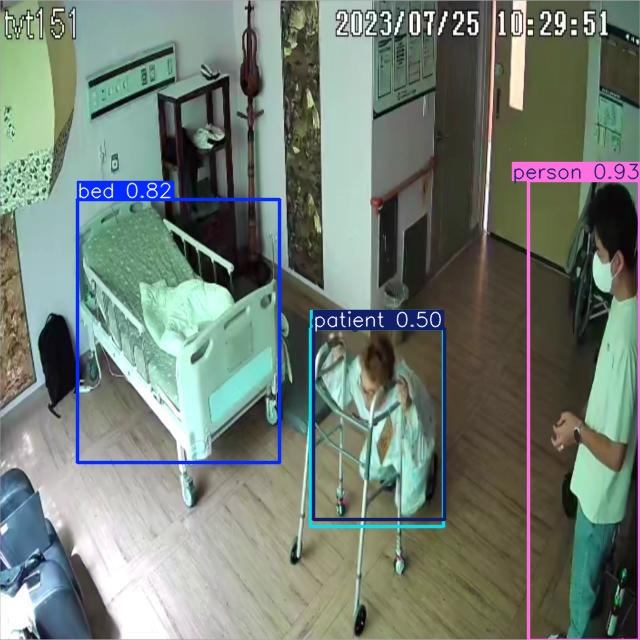

In [ ]:
from PIL import Image
img = Image.open('/content/drive/MyDrive/hanium/runs/detect/train42/10_100024_png_jpg.rf.8292ac02270a3a47049b740ea0f9da30.jpg')
img

# 5. 모델 재사용하기

In [4]:
from ultralytics import YOLO

# Load a model
trained_model = YOLO('/content/drive/MyDrive/hanium/runs/detect/train4/weights/last.pt')

In [5]:
trained_model.predict(source='/content/drive/MyDrive/hanium/fall_dataset/test/images/10_100024_png_jpg.rf.8292ac02270a3a47049b740ea0f9da30.jpg', save=True)


image 1/1 /content/drive/MyDrive/hanium/fall_dataset/test/images/10_100024_png_jpg.rf.8292ac02270a3a47049b740ea0f9da30.jpg: 320x320 1 bed, 1 danger, 1 patient, 1 person, 452.6ms
Speed: 16.8ms preprocess, 452.6ms inference, 53.6ms postprocess per image at shape (1, 3, 320, 320)
Results saved to runs/detect/predict


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'bed', 1: 'danger', 2: 'fall', 3: 'lie', 4: 'patient', 5: 'person', 6: 'sit'}
 obb: None
 orig_img: array([[[143, 142, 146],
         [112, 111, 115],
         [133, 132, 134],
         ...,
         [134, 143, 122],
         [136, 145, 124],
         [154, 163, 142]],
 
        [[ 93,  92,  96],
         [ 56,  55,  59],
         [ 77,  76,  78],
         ...,
         [ 91, 100,  79],
         [ 94, 103,  82],
         [113, 122, 101]],
 
        [[ 92,  89,  91],
         [ 52,  49,  51],
         [ 74,  71,  73],
         ...,
         [ 89,  99,  76],
         [ 94, 104,  81],
         [113, 123, 100]],
 
        ...,
 
        [[229, 230, 228],
         [255, 255, 254],
         [254, 255, 253],
         ...,
         [ 23,  24,  28],
         [ 25,  26,  30],
         [ 70,  71,  75]],
 
        [[226, 227, 223],
         [254, 2

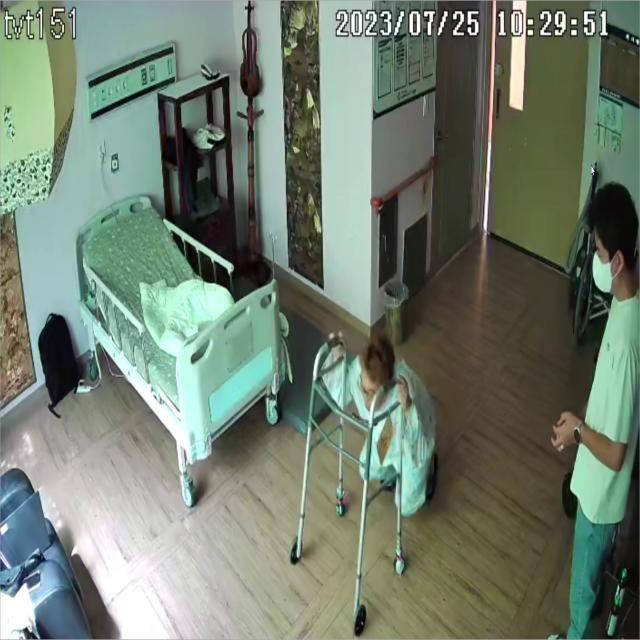

In [6]:


from PIL import Image
img = Image.open('/content/drive/MyDrive/hanium/fall_dataset/test/images/10_100024_png_jpg.rf.8292ac02270a3a47049b740ea0f9da30.jpg')
img

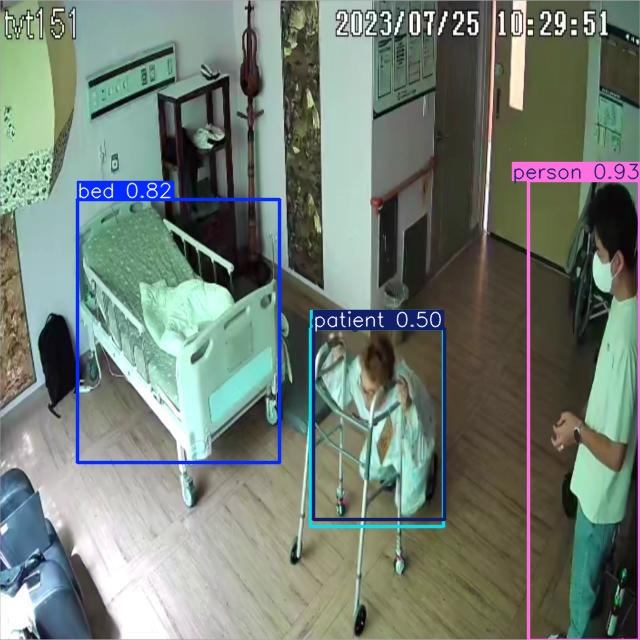

In [7]:
from PIL import Image
img = Image.open('/content/drive/MyDrive/hanium/runs/detect/predict/10_100024_png_jpg.rf.8292ac02270a3a47049b740ea0f9da30.jpg')
img

In [8]:
trained_model.predict(source='/content/drive/MyDrive/hanium/random_image/17_100185_png_jpg.rf.6cf6fd32fd04ed24b566878be7bafaa9.jpg', save=True)
trained_model.predict(source='/content/drive/MyDrive/hanium/random_image/5_100369_png_jpg.rf.485eeb11b1946c0e50c7aba00b75401e.jpg', save=True)
trained_model.predict(source='/content/drive/MyDrive/hanium/random_image/k107_100220_png_jpg.rf.118873ea33f0285fe5ad892909988386.jpg', save=True)
trained_model.predict(source='/content/drive/MyDrive/hanium/random_image/k107_100290_png_jpg.rf.cef460791215ed52ef38574283cdd304.jpg', save=True)


image 1/1 /content/drive/MyDrive/hanium/random_image/17_100185_png_jpg.rf.6cf6fd32fd04ed24b566878be7bafaa9.jpg: 320x320 4 beds, 1 danger, 1 fall, 1 patient, 1 person, 196.3ms
Speed: 1.3ms preprocess, 196.3ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 320)
Results saved to runs/detect/predict

image 1/1 /content/drive/MyDrive/hanium/random_image/5_100369_png_jpg.rf.485eeb11b1946c0e50c7aba00b75401e.jpg: 320x320 1 bed, 2 patients, 1 person, 190.3ms
Speed: 1.4ms preprocess, 190.3ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 320)
Results saved to runs/detect/predict

image 1/1 /content/drive/MyDrive/hanium/random_image/k107_100220_png_jpg.rf.118873ea33f0285fe5ad892909988386.jpg: 320x320 1 bed, 1 danger, 2 patients, 1 person, 183.3ms
Speed: 1.3ms preprocess, 183.3ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
Results saved to runs/detect/predict

image 1/1 /content/drive/MyDrive/hanium/random_image/k107_100290_png_jpg.rf.cef460791215ed5

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'bed', 1: 'danger', 2: 'fall', 3: 'lie', 4: 'patient', 5: 'person', 6: 'sit'}
 obb: None
 orig_img: array([[[141, 139, 139],
         [113, 111, 111],
         [146, 146, 146],
         ...,
         [135, 131, 130],
         [132, 128, 127],
         [159, 155, 154]],
 
        [[ 75,  73,  73],
         [ 56,  54,  54],
         [104, 104, 104],
         ...,
         [ 91,  87,  86],
         [ 88,  84,  83],
         [116, 112, 111]],
 
        [[ 72,  72,  72],
         [ 55,  55,  55],
         [109, 109, 109],
         ...,
         [ 88,  84,  83],
         [ 86,  82,  81],
         [114, 110, 109]],
 
        ...,
 
        [[234, 228, 217],
         [251, 248, 234],
         [254, 250, 232],
         ...,
         [ 23,  36,  52],
         [ 23,  36,  52],
         [ 63,  76,  90]],
 
        [[243, 239, 215],
         [252, 2

#=============사전 작업===================

# 데이터 셋팅

In [3]:
#Colab_Google drive 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 압축해제
# 내 드라이브는 원격서버가 아니라 로컬서버로 간주하므로 명령어 실행시 앞단에 !가 아닌 %명령을 입력함
%cd /content/drive/MyDrive/hanium
!mkdir fall_dataset
!unzip "Falldetector.v1i.yolov8.zip" -d fall_dataset
!ls

/content/drive/MyDrive/hanium
mkdir: cannot create directory ‘fall_dataset’: File exists
Archive:  Falldetector.v1i.yolov8.zip
replace fall_dataset/README.dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: fall_dataset  Falldetector.v1i.yolov8.zip  random_image  runs  yolov8s.pt


In [ ]:
!file "Falldetector.v1i.yolov8.zip"

Falldetector.v1i.yolov8.zip: Zip archive data, at least v2.0 to extract, compression method=deflate


In [ ]:
# 각종 데이터 제공
#https://universe.roboflow.com/